# Model-1: Bigger Baseline Model
This version simply increases the depth and number of channels in each network.

In [35]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets

In [36]:
try:
    from torchinfo import summary
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchinfo"])
    from torchinfo import summary

In [37]:
try:
    import torchmetrics
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "torchmetrics"])
    import torchmetrics

In [38]:
import os
repo_url = "https://raw.githubusercontent.com/vardanskamra/Deep-Multimedia-Steganography/main/utils"
files = [
    "__init__.py",
    "test.py",
    "train.py",
    "metrics.py",
    "transforms.py",
    "visualizations.py",
    "inference.py"
]
os.makedirs("utils", exist_ok=True)

for file in files:
    file_url = f"{repo_url}/{file}"
    os.system(f"curl -s {file_url} -o utils/{file}")

print("Downloaded all utils files successfully!")

Downloaded all utils files successfully!


In [39]:
import sys
sys.path.append("./utils") 

In [40]:
import utils

from utils.transforms import train_test_transform
from utils.metrics import loss_function
from utils.train import train
from utils.test import test

from utils.visualizations import plot_metrics
from utils.visualizations import visualize_images

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=train_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Train DataLoader Length: {len(train_loader)}")
print(f"Test DataLoader Length: {len(test_loader)}")

sample, label = next(iter(train_loader))
print(f"Sample Shape: {sample.shape}")
print(f"Label Shape: {label.shape}")

Train Dataset Length: 50000
Test Dataset Length: 10000
Train DataLoader Length: 1563
Test DataLoader Length: 313
Sample Shape: torch.Size([32, 3, 128, 128])
Label Shape: torch.Size([32])


In [44]:
class PrepNetwork(nn.Module):
  def __init__(self):
    super(PrepNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, secret):
    x = self.relu(self.conv1(secret))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.conv4(x)
    return x

In [45]:
class HidingNetwork(nn.Module):
  def __init__(self):
    super(HidingNetwork, self).__init__()
    self.conv1 = nn.Conv2d(6, 128, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, cover, secret_prepared):
    x = torch.cat([cover, secret_prepared], dim=1)
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.conv4(x)
    return x

In [46]:
class RevealNetwork(nn.Module):
  def __init__(self):
    super(RevealNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, stego):
    x = self.relu(self.conv1(stego))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.conv4(x)
    return x

In [47]:
print(f"Device: {device}")
prep_net = nn.DataParallel(PrepNetwork()).to(device)
hide_net = nn.DataParallel(HidingNetwork()).to(device)
reveal_net = nn.DataParallel(RevealNetwork()).to(device)

Device: cuda


In [59]:
print("PrepNetwork Summary:")
print(summary(prep_net, input_size=(32, 3, 128, 128)))

cover = torch.randn(32, 3, 128, 128)
secret_prepared = torch.randn(32, 3, 128, 128)

print("\nHidingNetwork Summary:")
print(summary(hide_net, input_data=[cover, secret_prepared])) # 6 channels (cover + secret_prepared)

print("\nRevealNetwork Summary:")
print(summary(reveal_net, input_size=(32, 3, 128, 128)))

PrepNetwork Summary:
Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [32, 3, 128, 128]         --
├─PrepNetwork: 1-1                       [16, 3, 128, 128]         302,211
├─PrepNetwork: 1-4                       --                        (recursive)
│    └─Conv2d: 2-1                       [16, 128, 128, 128]       3,584
├─PrepNetwork: 1-3                       [16, 3, 128, 128]         --
├─PrepNetwork: 1-4                       --                        (recursive)
│    └─Conv2d: 2-2                       [16, 128, 128, 128]       --
│    └─ReLU: 2-3                         [16, 128, 128, 128]       --
│    └─Conv2d: 2-4                       [16, 128, 128, 128]       147,584
│    └─ReLU: 2-5                         [16, 128, 128, 128]       --
│    └─Conv2d: 2-6                       [16, 128, 128, 128]       --
│    └─ReLU: 2-7                         [16, 128, 128, 128]       --
│    └─Conv2d: 2-8               

In [48]:
optimizer = torch.optim.Adam(list(prep_net.parameters()) +
                       list(hide_net.parameters()) +
                       list(reveal_net.parameters()), lr=0.001)

In [49]:
train_metrics = train(dataloader=train_loader,
                prep_net=prep_net,
                hide_net=hide_net,
                reveal_net=reveal_net,
                optimizer=optimizer,
                loss_fn=loss_function,
                beta=0.75,
                epochs=25,
                device=device)

Epoch [1/25], Loss: 0.0183, PSNR: 25.0811, SSIM: 0.9112, NC: 0.8516, Pixel Loss (Cover-Stego): 0.0424, Pixel Loss (Secret-Revealed): 0.0918
Epoch [2/25], Loss: 0.0096, PSNR: 26.7689, SSIM: 0.9441, NC: 0.9348, Pixel Loss (Cover-Stego): 0.0326, Pixel Loss (Secret-Revealed): 0.0683
Epoch [3/25], Loss: 0.0092, PSNR: 27.3128, SSIM: 0.9507, NC: 0.9343, Pixel Loss (Cover-Stego): 0.0305, Pixel Loss (Secret-Revealed): 0.0668
Epoch [4/25], Loss: 0.0089, PSNR: 27.5021, SSIM: 0.9533, NC: 0.9357, Pixel Loss (Cover-Stego): 0.0294, Pixel Loss (Secret-Revealed): 0.0655
Epoch [5/25], Loss: 0.0094, PSNR: 27.2658, SSIM: 0.9492, NC: 0.9347, Pixel Loss (Cover-Stego): 0.0309, Pixel Loss (Secret-Revealed): 0.0670
Epoch [6/25], Loss: 0.0080, PSNR: 26.5753, SSIM: 0.9404, NC: 0.9475, Pixel Loss (Cover-Stego): 0.0344, Pixel Loss (Secret-Revealed): 0.0598
Epoch [7/25], Loss: 0.0060, PSNR: 25.5957, SSIM: 0.9222, NC: 0.9733, Pixel Loss (Cover-Stego): 0.0389, Pixel Loss (Secret-Revealed): 0.0466
Epoch [8/25], Loss: 

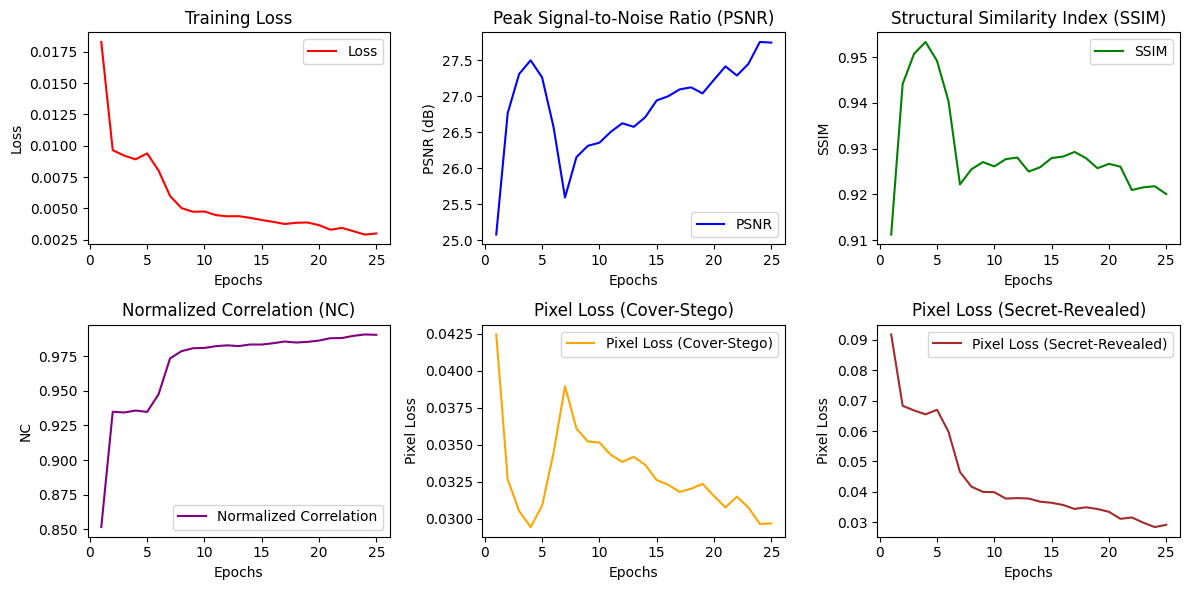


Final Evaluation Metrics:
Final Loss: 0.0030
Final PSNR: 27.7483 dB
Final SSIM: 0.9201
Final Normalized Correlation (NC): 0.9903
Final Pixel Loss (Cover-Stego): 0.0297
Final Pixel Loss (Secret-Revealed): 0.0292



In [50]:
plot_metrics(train_metrics)

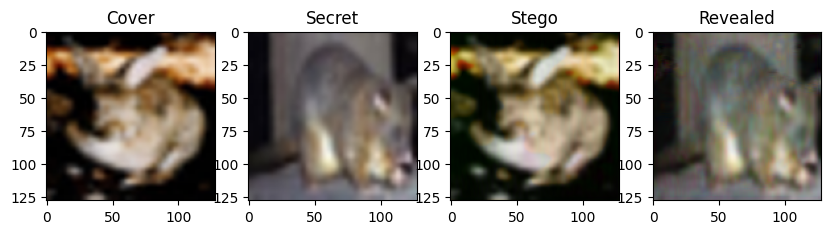

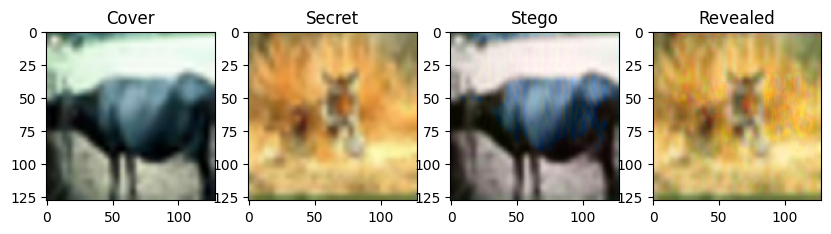

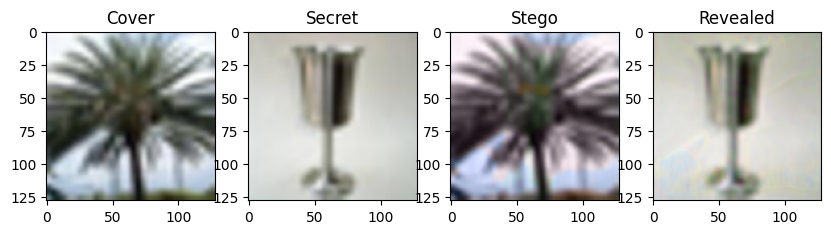

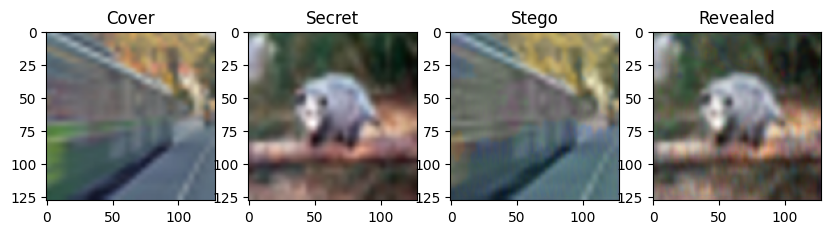

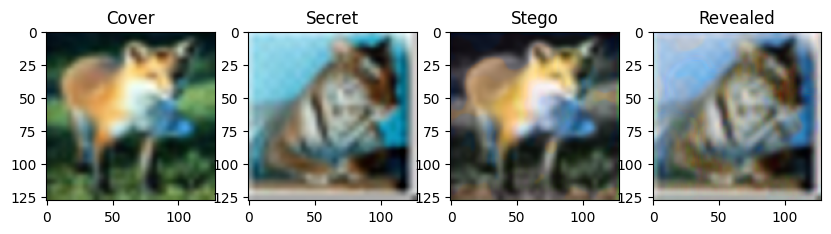

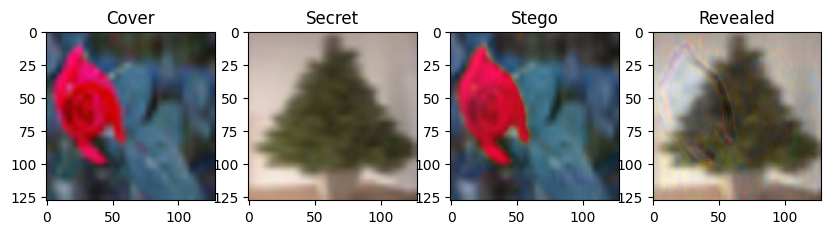

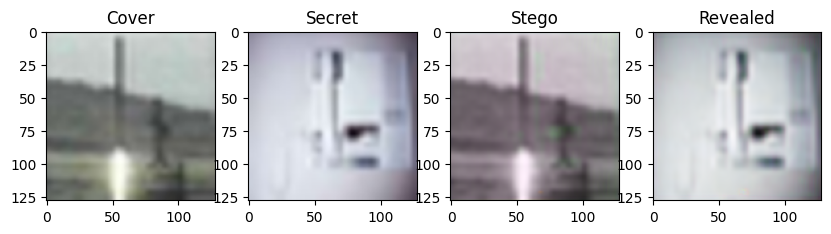

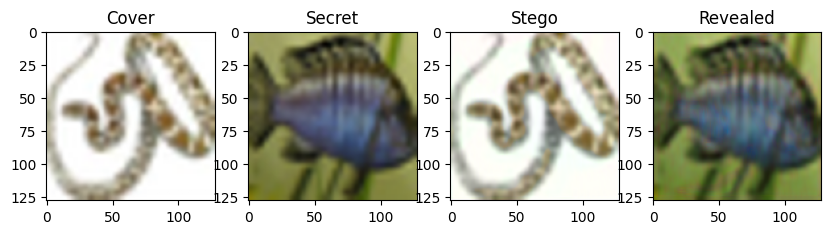

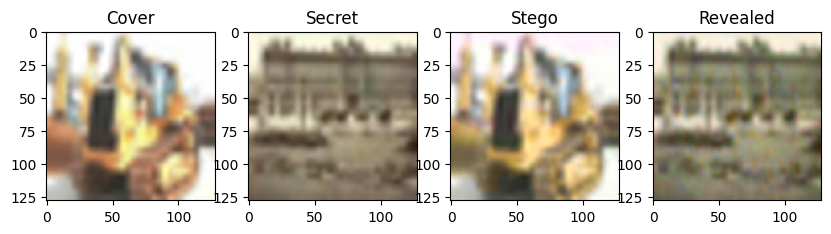

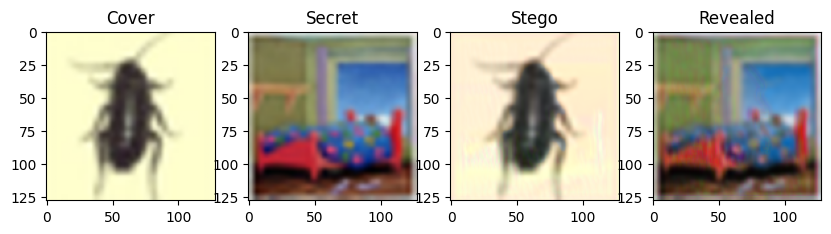

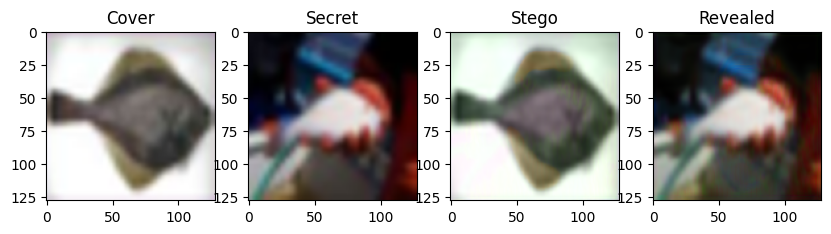

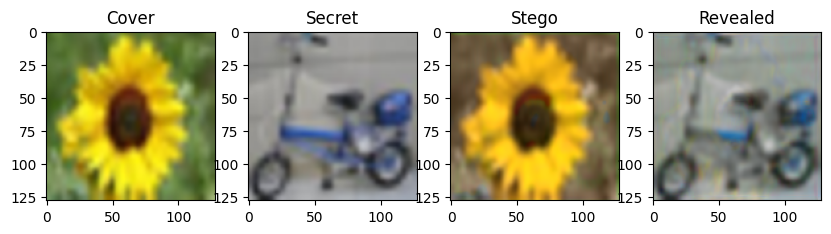

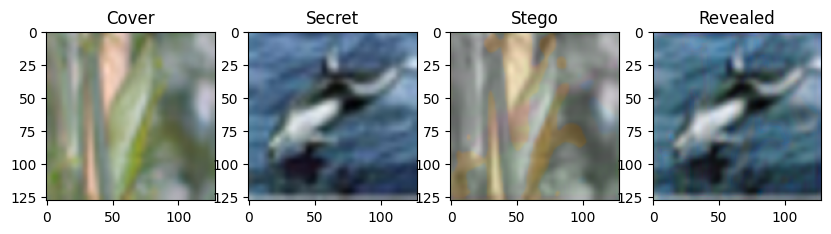

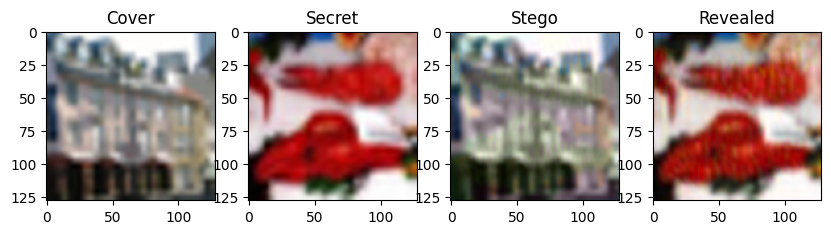

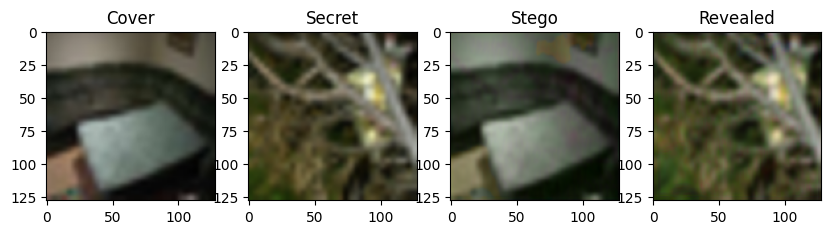


Test Results: Loss: 0.0026, PSNR: 27.7707, SSIM: 0.9214, NC: 0.9920, Pixel Loss (Cover-Stego): 0.0296, Pixel Loss (Secret-Revealed): 0.0237



In [51]:
test_metrics = test(prep_net=prep_net,
               hide_net=hide_net,
               reveal_net=reveal_net,
               dataloader=test_loader,
               loss_fn = loss_function,
               beta = 0.75,
               visualize = True,
               device=device)

In [55]:
checkpoint = {
    'epoch': 25, # New training stars from epoch 25, we've done 0-24
    'prep_net_state_dict': prep_net.module.state_dict(),
    'hide_net_state_dict': hide_net.module.state_dict(),
    'reveal_net_state_dict': reveal_net.module.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, "model_checkpoint.pth")

In [56]:
torch.save(prep_net.state_dict(), "/kaggle/working/prep_net.pth")
torch.save(hide_net.state_dict(), "/kaggle/working/hide_net.pth")
torch.save(reveal_net.state_dict(), "/kaggle/working/reveal_net.pth")